<a href="https://colab.research.google.com/github/ChiefGupta/Project1/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/My Drive/database/train.tsv', sep = '\t')

In [4]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [5]:
train.shape, test.shape

((1185770, 8), (296765, 8))

In [6]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1185770 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1185770 non-null  int64  
 1   name               1185770 non-null  object 
 2   item_condition_id  1185770 non-null  int64  
 3   category_name      1180691 non-null  object 
 4   brand_name         679839 non-null   object 
 5   price              1185770 non-null  float64
 6   shipping           1185770 non-null  int64  
 7   item_description   1185765 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 81.4+ MB


In [8]:
train.price.describe()

,price
count,1.185770e+06
mean,2.672450e+01
std,3.853304e+01
min,0.000000e+00
25%,1.000000e+01
50%,1.700000e+01
75%,2.900000e+01
max,2.006000e+03


Text(0.5, 1.0, 'Price Distribution')

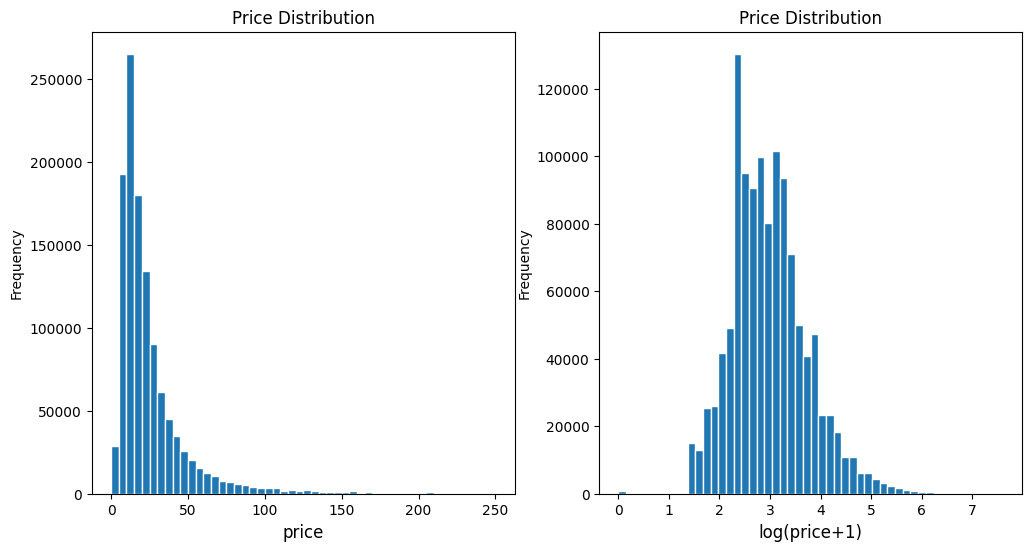

In [9]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [10]:
train['shipping'].value_counts() / len(train)

,count
shipping,
0,0.552576
1,0.447424


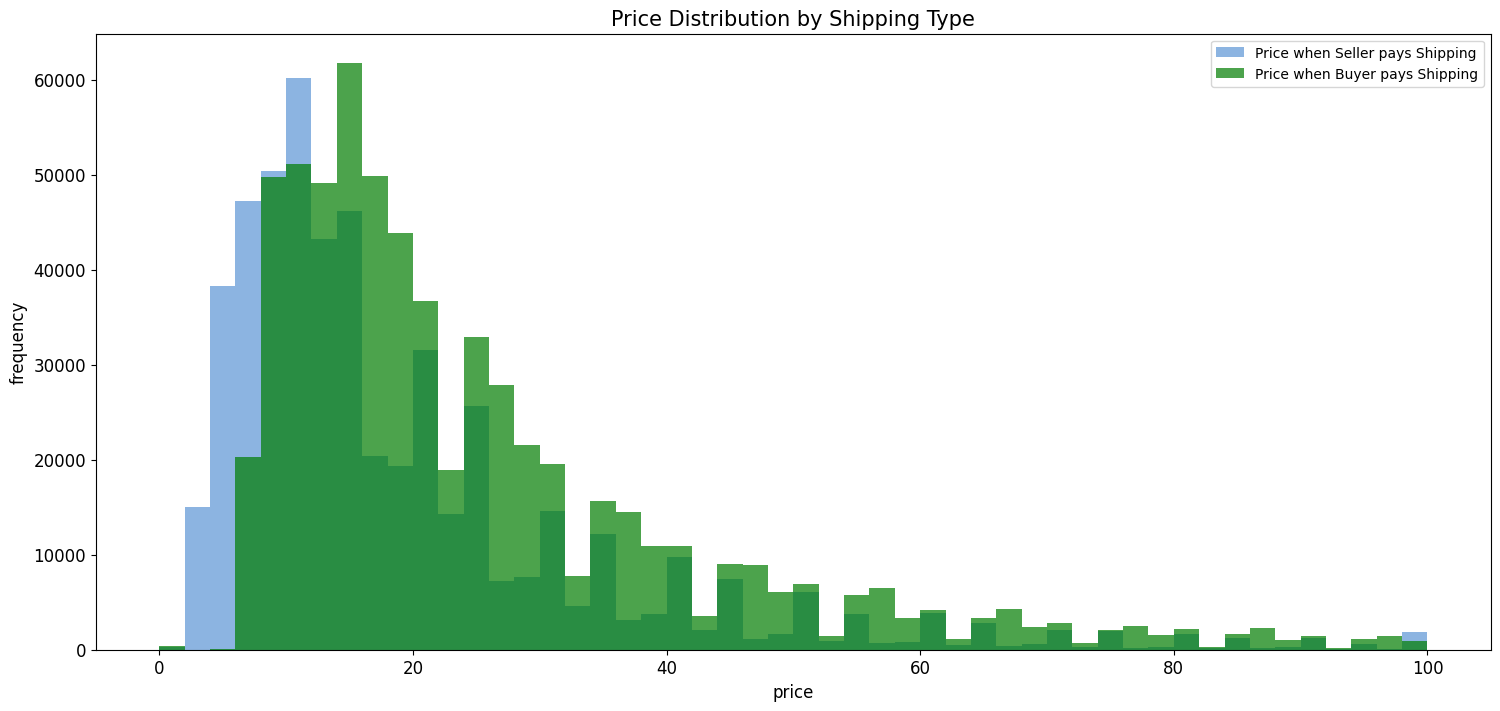

In [11]:
shipping_fee_by_buyer = train.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[df['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [12]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.52 if seller pays shipping
The average price is 30.13 if buyer pays shipping


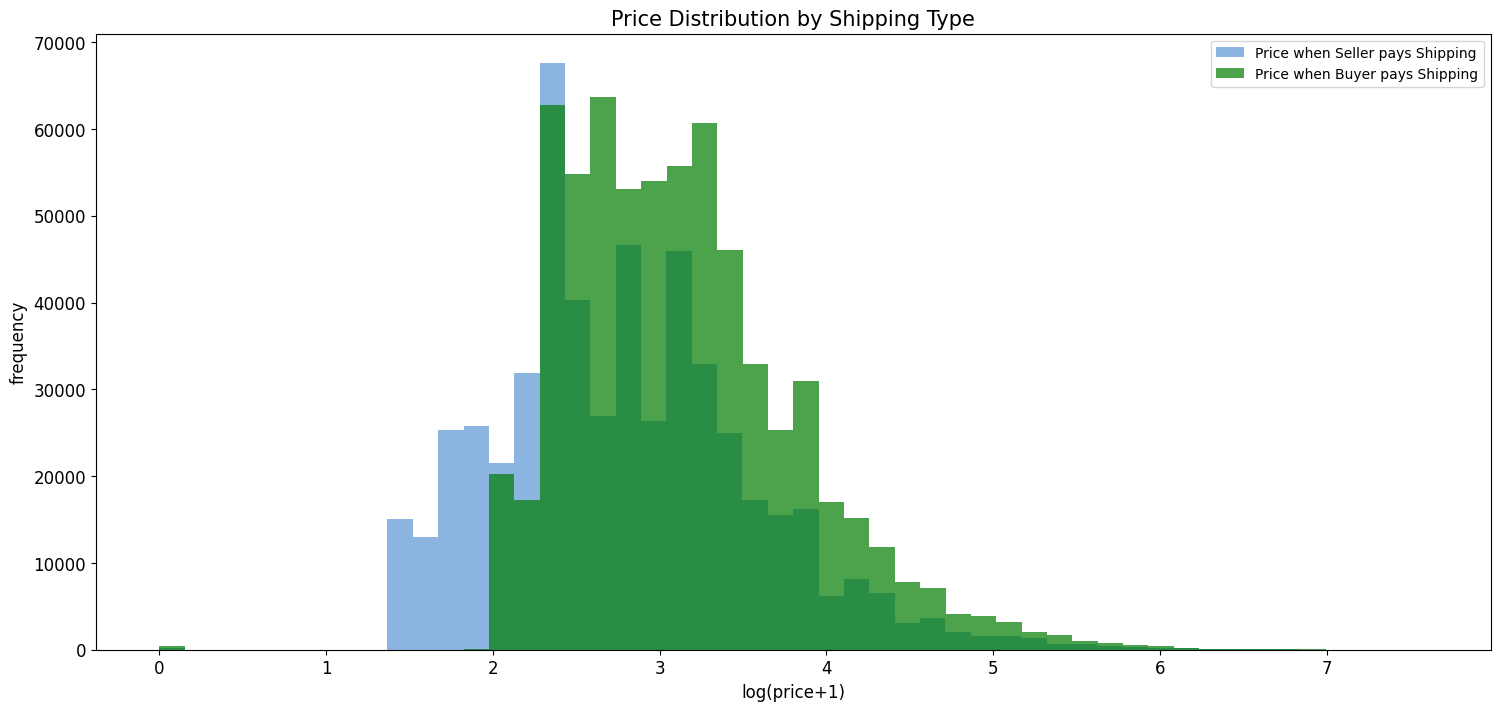

In [13]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [14]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 1261 unique values in category name column


In [15]:
train['category_name'].value_counts()[:10]

,count
category_name,
"Women/Athletic Apparel/Pants, Tights, Leggings",48163
Women/Tops & Blouses/T-Shirts,37140
Beauty/Makeup/Face,27438
Beauty/Makeup/Lips,23811
Electronics/Video Games & Consoles/Games,21209
Beauty/Makeup/Eyes,20163
"Electronics/Cell Phones & Accessories/Cases, Covers & Skins",19712
Women/Underwear/Bras,16833
Women/Tops & Blouses/Blouse,16297


<ipython-input-16-5e06f90eeb1f>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))


<Axes: xlabel='item_condition_id', ylabel='price'>

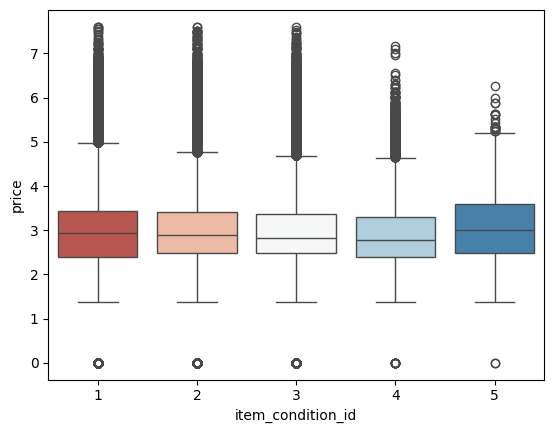

In [16]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))

In [17]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [18]:
print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())

There are 5079 items that do not have a category name.


In [19]:
print('There are %d items that do not have a brand name.' %train['brand_name'].isnull().sum())

There are 505931 items that do not have a brand name.


In [20]:
print('There are %d items that do not have a description.' %train['item_description'].isnull().sum())

There are 5 items that do not have a description.


In [21]:
def handle_missing_inplace(dataset):
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].replace('No description yet,''missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)

In [22]:
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

In [23]:
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [24]:
df = pd.read_csv('/content/drive/My Drive/database/train.tsv', sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])

In [25]:
train = train[train.price != 0].reset_index(drop=True)

In [26]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [27]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

<ipython-input-21-ad69a35d0b07>:4: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  dataset['item_description'].replace('No description yet,''missing', inplace=True)


In [28]:
merge.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...
2,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity
3,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
4,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.


In [29]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])

In [30]:
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [31]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [32]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [33]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

<ipython-input-33-921a540716bf>:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)


In [34]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [35]:
sparse_merge.shape

(1481841, 72753)

In [36]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [37]:
sparse_merge.shape

(1481841, 72287)

In [38]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [39]:
train_X = lgb.Dataset(X, label=y)

In [40]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

In [41]:
!pip install lightgbm --upgrade # upgrade to the latest version of lightgbm

import lightgbm as lgb

# Define the callback function
log_evaluation = lgb.log_evaluation(period=100)

gbm = lgb.train(params,
                train_set=train_X,
                num_boost_round=3200,
                callbacks=[log_evaluation]) # Pass the callback function as a list

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.4.0
    Uninstalling lightgbm-4.4.0:
      Successfully uninstalled lightgbm-4.4.0


In [45]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [43]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.4617810036986652


In [44]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>